In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# --- 1. SETUP ---

# Connect Google Colab to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install the library for handling imbalanced datasets
!pip install imbalanced-learn

# Import all necessary libraries
import os
import cv2 # OpenCV for image processing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf

print("Libraries installed and imported successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries installed and imported successfully.


In [ ]:
# --- 2. LOAD IMAGE PATHS ---

# !!! IMPORTANT: Change this path to where your dataset is located in your Google Drive !!!
DATASET_PATH = '/content/drive/MyDrive/archive/DATASET'

image_paths = []
labels = []

# Get the class names (sub-folder names)
class_names = sorted(os.listdir(DATASET_PATH))
print(f"Found classes: {class_names}")

# Loop through each class folder
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    # Loop through each image in the class folder
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(class_name)

print(f"Total images found: {len(image_paths)}")
print(f"Total labels found: {len(labels)}")

Found classes: ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
Total images found: 645
Total labels found: 645


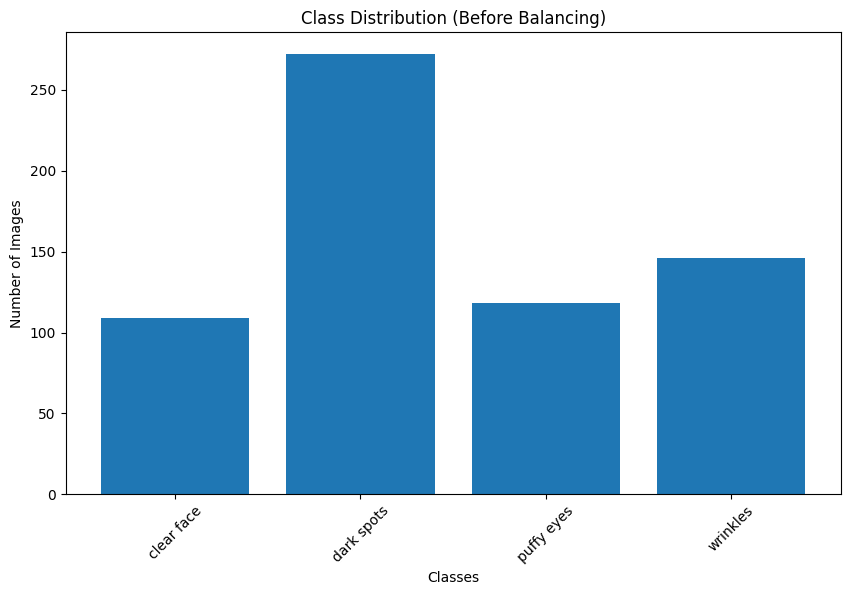

In [ ]:
# --- 3. VISUALIZE IMBALANCE ---

# Count the number of images per class
unique_labels, counts = np.unique(labels, return_counts=True)

# Create a bar chart to show the imbalance
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts)
plt.title('Class Distribution (Before Balancing)')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# --- 4. IMAGE LOADING AND PREPROCESSING ---

IMG_SIZE = 224
images = []
processed_labels = []

for img_path, label in zip(image_paths, labels):
    try:
        # Read image using OpenCV
        img = cv2.imread(img_path)
        # Convert from BGR (OpenCV default) to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to the required size
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        processed_labels.append(label)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Convert lists to NumPy arrays
images = np.array(images, dtype='float32')
processed_labels = np.array(processed_labels)

# Normalize pixel values from [0, 255] to [0, 1]
images /= 255.0

# Encode string labels (e.g., 'wrinkles') into integers (e.g., 0, 1, 2)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(processed_labels)

print(f"Shape of image data: {images.shape}")
print(f"Shape of label data: {integer_labels.shape}")

Shape of image data: (645, 224, 224, 3)
Shape of label data: (645,)


In [ ]:
# --- 5. APPLYING SMOTE TO BALANCE DATA ---

# SMOTE works on a 2D array, so we need to flatten the images first
# (num_images, 224, 224, 3) -> (num_images, 224 * 224 * 3)
num_images = images.shape[0]
images_flattened = images.reshape(num_images, -1)

print(f"Shape of flattened images: {images_flattened.shape}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(images_flattened, integer_labels)

print("SMOTE applied successfully.")

# Reshape the images back to their original 3D shape (224x224x3)
X_balanced = X_balanced.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(f"Shape of balanced image data: {X_balanced.shape}")
print(f"Shape of balanced label data: {y_balanced.shape}")

Shape of flattened images: (645, 150528)
SMOTE applied successfully.
Shape of balanced image data: (1088, 224, 224, 3)
Shape of balanced label data: (1088,)


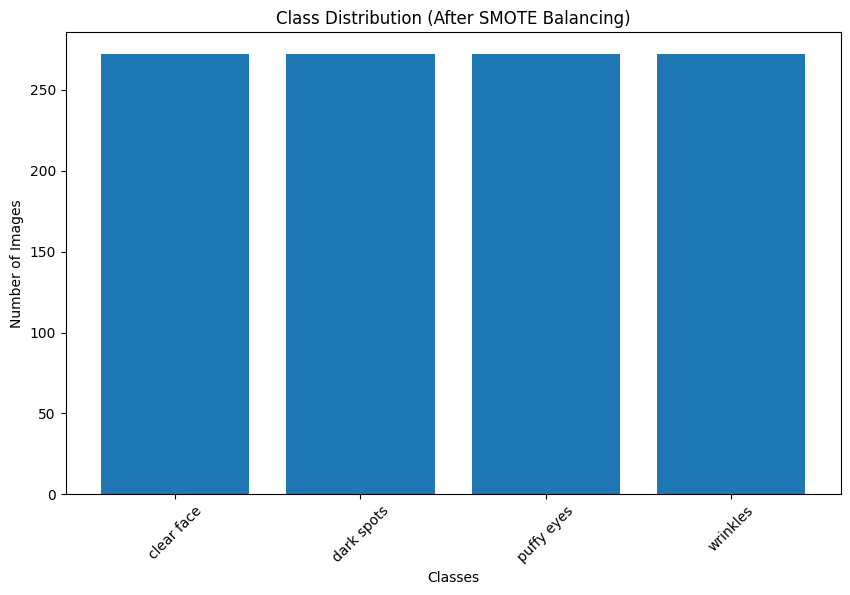

In [ ]:
# --- 6. VISUALIZE BALANCED DATA ---

# Count the number of images per class after SMOTE
unique_labels_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
class_names_balanced = label_encoder.inverse_transform(unique_labels_balanced)

# Create a bar chart to show the balanced distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names_balanced, counts_balanced)
plt.title('Class Distribution (After SMOTE Balancing)')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# --- 7. SPLIT AND SAVE DATA TO NEW FOLDERS ---

# First, split the balanced data into training (80%) and validation (20%) sets
# We still do this first to get the indices for training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training set size: {len(X_train)} images")
print(f"Validation set size: {len(X_val)} images")

# !!! IMPORTANT: Define the path for your new, processed dataset !!!
OUTPUT_DIR = '/content/drive/MyDrive/archive/processed_skin_dataset'

# Create base directories for train and validation sets
train_dir = os.path.join(OUTPUT_DIR, 'train')
val_dir = os.path.join(OUTPUT_DIR, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create class subdirectories in both train and validation folders
class_names = label_encoder.classes_
for name in class_names:
    os.makedirs(os.path.join(train_dir, name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, name), exist_ok=True)

print(f"Created directory structure at: {OUTPUT_DIR}")

# --- Function to save images ---
def save_images(images, labels, output_folder):
    print(f"Saving images to {output_folder}...")
    for i, (image, label_index) in enumerate(zip(images, labels)):
        # Get the class name from the integer label
        class_name = label_encoder.inverse_transform([label_index])[0]

        # Define the output path for the image
        filename = f"image_{i}.png"
        save_path = os.path.join(output_folder, class_name, filename)

        # Prepare image for saving with OpenCV:
        # 1. Denormalize from [0, 1] to [0, 255]
        # 2. Convert to 8-bit integer
        # 3. Convert from RGB (used for training) to BGR (used by OpenCV)
        image_to_save = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        # Save the image
        cv2.imwrite(save_path, image_to_save)
    print("Saving complete.")

# Save the training images
save_images(X_train, y_train, train_dir)

# Save the validation images
save_images(X_val, y_val, val_dir)

print("\nAll preprocessed and balanced images have been saved successfully!")

Training set size: 870 images
Validation set size: 218 images
Created directory structure at: /content/drive/MyDrive/archive/processed_skin_dataset
Saving images to /content/drive/MyDrive/archive/processed_skin_dataset/train...
Saving complete.
Saving images to /content/drive/MyDrive/archive/processed_skin_dataset/validation...
Saving complete.

All preprocessed and balanced images have been saved successfully!


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# --- 1. SETUP: LIBRARIES, PATHS, AND PARAMETERS ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# !!! IMPORTANT: Set the path to your PROCESSED dataset !!!
DATASET_PATH = '/content/drive/MyDrive/archive/processed_skin_dataset'
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
VALIDATION_DIR = os.path.join(DATASET_PATH, 'validation')

# Model & Training Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS


# --- 2. DATA PIPELINE (Using the robust tf.data.Dataset) ---
print("Setting up tf.data pipeline...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE), interpolation='bicubic',
    batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE), interpolation='bicubic',
    batch_size=BATCH_SIZE, shuffle=False
)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found classes: {class_names}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, augment=False):
    # --- CHANGE 1: Use the correct preprocessing for EfficientNet ---
    ds = ds.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
print("Data pipeline created successfully for EfficientNetB0.")


# --- 3. MODEL BUILDING (Using EfficientNetB0) ---
print("\nBuilding the model with EfficientNetB0...")
# --- CHANGE 2: Use EfficientNetB0 as the base model ---
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False # Start with the base model frozen

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


# --- 4. PHASE 1: INITIAL TRAINING (Head Only) ---
print("\nCompiling model for head training...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(f"Starting initial training for {INITIAL_EPOCHS} epochs...")
history = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds
)


# --- 5. PHASE 2: FINE-TUNING ---
print("\nPreparing for fine-tuning...")
base_model.trainable = True

# --- CHANGE 3: Adjust the number of layers to fine-tune for EfficientNetB0 ---
fine_tune_at = -20 # Unfreeze the top 20 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model re-compiled for fine-tuning.")

print(f"Starting fine-tuning for {FINE_TUNE_EPOCHS} more epochs...")
history_fine_tune = model.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCHS,
    validation_data=val_ds
)
print("Fine-tuning finished.")

Mounted at /content/drive
Setting up tf.data pipeline...
Found 870 files belonging to 4 classes.
Found 218 files belonging to 4 classes.
Found classes: ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
Data pipeline created successfully for ResNet50V2.

Building the model with ResNet50V2...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Compiling model for head training...
Starting initial training for 10 epochs...
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.4325 - loss: 1.3485 - val_accuracy: 0.7661 - val_loss: 0.6525
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.8129 - loss: 0.5628 - val_accuracy: 0.8028 - val_loss: 0.5463
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - accuracy: 0.8474 - loss: 0.4284 - val_accuracy: 0.8165 - val_loss: 0.4936
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.8613 - loss: 0.4251 - val_accuracy: 0.8394 - val_loss: 0.4346
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 

In [ ]:
# --- 7. SAVE FINAL MODEL TO GOOGLE DRIVE ---

# Define the path where you want to save the model in your Google Drive
# It's a good practice to create a folder for your models first.
drive_save_path = '/content/drive/MyDrive/model_skin.h5'

# Save the model to the specified path
model.save(drive_save_path)

print(f"✅ Model successfully saved to your Google Drive at: {drive_save_path}")

✅ Model successfully saved to your Google Drive at: /content/drive/MyDrive/model_skin.h5


In [ ]:
# --- 8. DOWNLOAD MODEL TO LOCAL SYSTEM ---
from google.colab import files

# The model must first be saved to the temporary Colab session
local_filename = 'model_skin.h5'
model.save(local_filename)

# Trigger the browser download for that file
print(f"⬇️ Starting download of {local_filename}...")
files.download(local_filename)

⬇️ Starting download of model_skin.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !!! Use the exact path where you saved your model !!!
model_path = '/content/drive/MyDrive/model_skin.h5'

print(f"Loading model from: {model_path}")

# Load the model from the .h5 file
try:
    loaded_model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f" Error loading model: {e}")

# --- 3. VERIFY THE ARCHITECTURE ---

# Print the model summary to check the layers and parameters
print("\nVerifying model summary:")
loaded_model.summary()

# Plot the model architecture and save it as an image
print("\nGenerating model plot...")
plot_path = '/content/drive/MyDrive/archive/plot.png'
tf.keras.utils.plot_model(
    loaded_model,
    to_file=plot_path,
    show_shapes=True,
    show_layer_activations=True
)

print(f" Model plot saved to: {plot_path}")
print("You can now view the plot image in your Google Drive.")

Loading model from: /content/drive/MyDrive/model_skin.h5


✅ Model loaded successfully!

Verifying model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,615,942 (93.90 MB)

 Trainable params: 16,019,972 (61.11 MB)

 Non-trainable params: 8,595,968 (32.79 MB)

 Optimizer params: 2 (12.00 B)


Generating model plot...
✅ Model plot saved to: /content/drive/MyDrive/archive/plot.png
You can now view the plot image in your Google Drive.


✅ Training history loaded successfully.


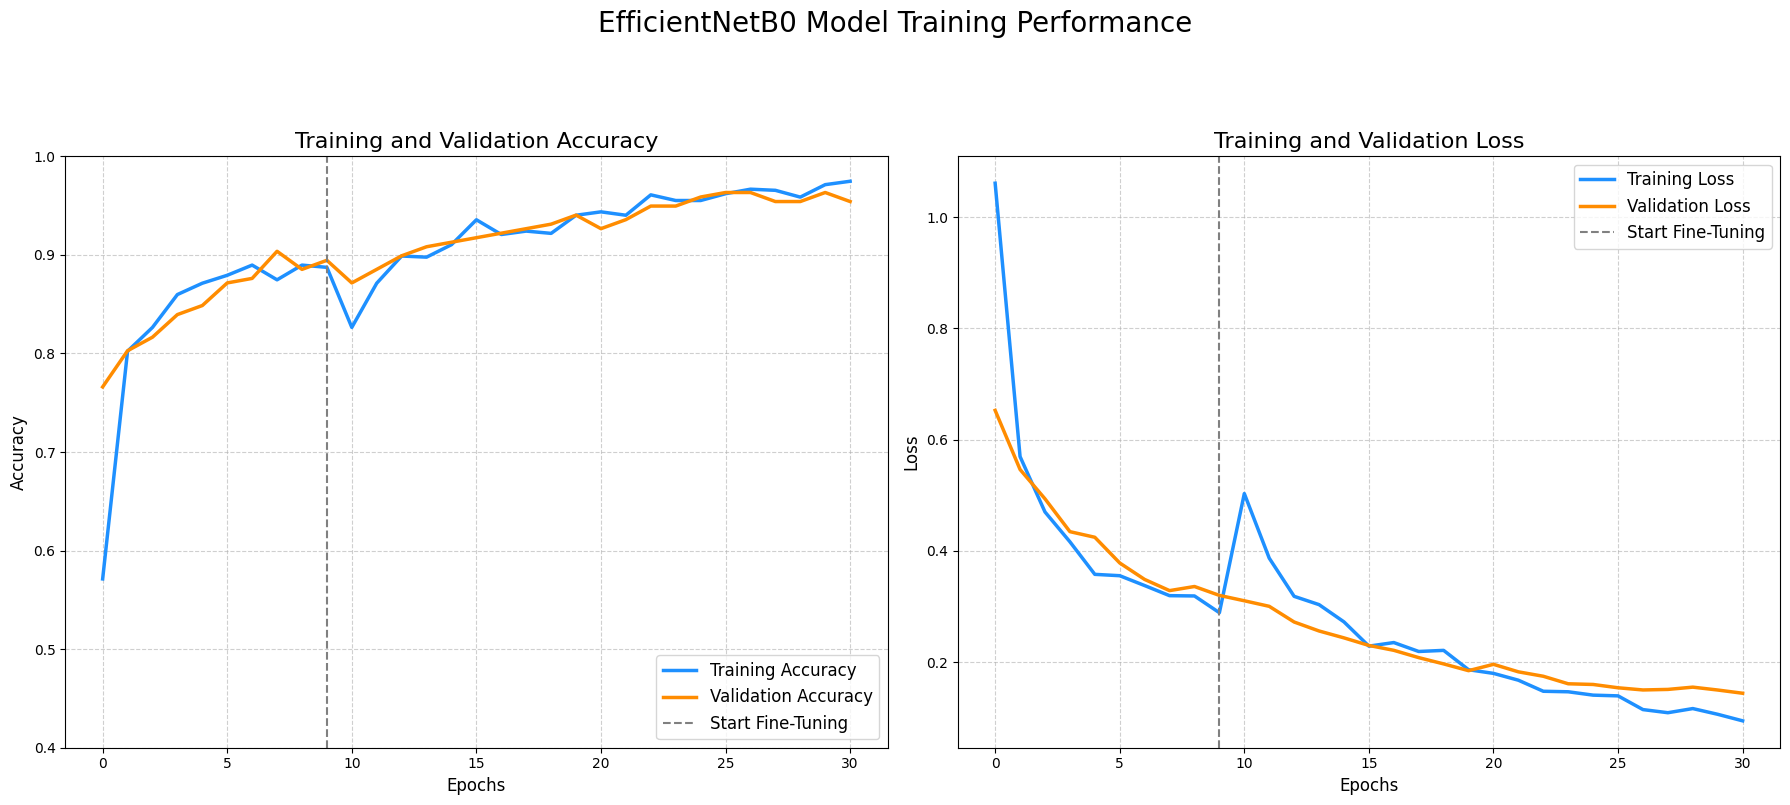

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. COMBINE HISTORY DATA ---
# Load the combined history from the saved file
history_path = '/content/drive/MyDrive/archive/training_history.npy'
try:
    combined_history = np.load(history_path, allow_pickle=True).item()
    acc = combined_history['accuracy']
    val_acc = combined_history['val_accuracy']
    loss = combined_history['loss']
    val_loss = combined_history['val_loss']
    print("✅ Training history loaded successfully.")
except FileNotFoundError:
    print(f" Error: Training history file not found at {history_path}")
    print(" Please ensure the file exists and the path is correct.")
    # Exit or handle the error appropriately if the file is not found
    exit()


# --- 2. CREATE THE PLOTS (WITH THE FIX) ---

# THE FIX: Create an x-axis range that exactly matches the length of our data (31 points).
epochs_range = range(len(acc))

plt.figure(figsize=(18, 8))

# --- Plot for Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='dodgerblue', linewidth=2.5)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='darkorange', linewidth=2.5)
# Assuming INITIAL_EPOCHS was defined in the training cell and saved in history
initial_epochs_from_history = len(history.history['accuracy']) if 'history' in locals() else 10 # Default to 10 if history is not available
plt.axvline(initial_epochs_from_history - 1, linestyle='--', color='gray', label='Start Fine-Tuning')
plt.legend(loc='lower right', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0.4, 1.0])
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot for Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='dodgerblue', linewidth=2.5)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='darkorange', linewidth=2.5)
plt.axvline(initial_epochs_from_history - 1, linestyle='--', color='gray', label='Start Fine-Tuning')
plt.legend(loc='upper right', fontsize=12)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add an overall title
plt.suptitle('EfficientNetB0 Model Training Performance', fontsize=20, y=1.03)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import numpy as np

# --- Combine the two history dictionaries into one ---
combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

# --- Define the save path in your Google Drive ---
history_path = '/content/drive/MyDrive/archive/training_history.npy'

# --- Save the combined history ---
np.save(history_path, combined_history)

print(f"✅ Training history saved successfully to: {history_path}")

✅ Training history saved successfully to: /content/drive/MyDrive/archive/training_history.npy


Mounted at /content/drive


✅ Model loaded successfully!
Found 218 files belonging to 4 classes.
Loaded validation data with classes: ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']

Making predictions on the validation set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step
Predictions complete.


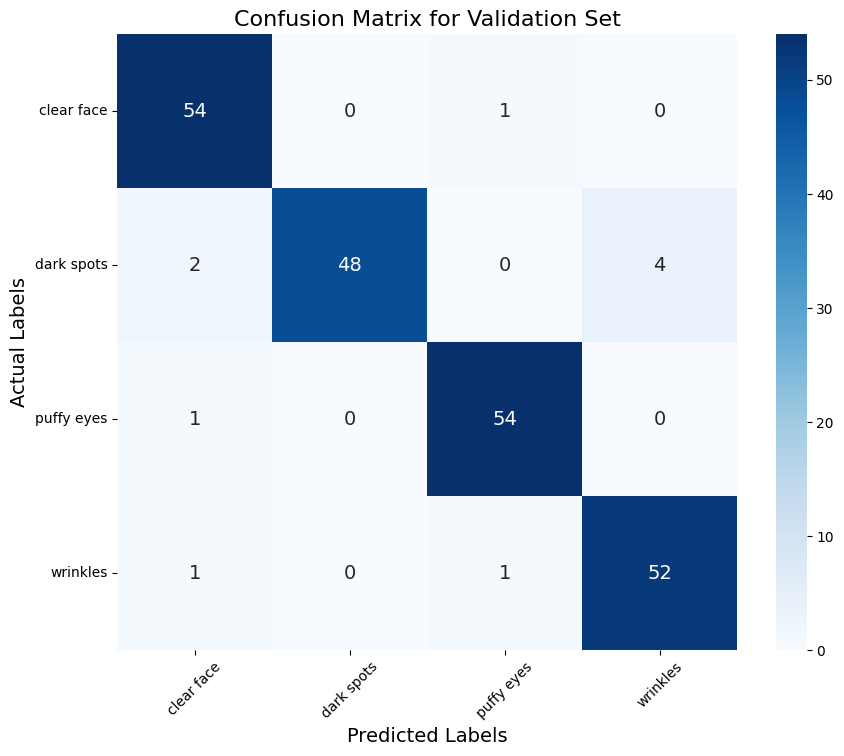

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from google.colab import drive
import os

# --- 1. LOAD YOUR SAVED MODEL ---
drive.mount('/content/drive', force_remount=True)

# !!! Use the exact path where you saved your model !!!
model_path = '/content/drive/MyDrive/model_skin.h5'
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully!")


# --- 2. LOAD THE VALIDATION DATASET ---
# We need to load the validation images to test the model
VALIDATION_DIR = '/content/drive/MyDrive/archive/processed_skin_dataset/validation'
IMG_SIZE = 224
BATCH_SIZE = 32

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='bicubic',
    batch_size=BATCH_SIZE,
    shuffle=False # IMPORTANT: Do not shuffle so labels and predictions align
)

# Access class_names BEFORE applying prefetch
class_names = val_ds.class_names

# Apply the same ResNetV2 preprocessing
def prepare(ds):
    ds = ds.map(lambda x, y: (tf.keras.applications.resnet_v2.preprocess_input(x), y))
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = prepare(val_ds)

print(f"Loaded validation data with classes: {class_names}")


# --- 3. MAKE PREDICTIONS AND GET TRUE LABELS ---

# Get the true labels from the dataset
y_true_one_hot = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)

# Make predictions on the entire validation set
print("\nMaking predictions on the validation set...")
predictions = model.predict(val_ds)
y_pred = np.argmax(predictions, axis=1)
print("Predictions complete.")


# --- 4. COMPUTE AND PLOT THE CONFUSION MATRIX ---

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('Actual Labels', fontsize=14)
plt.title('Confusion Matrix for Validation Set', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:

# You need the class names in the exact same order as they were during training
class_names = ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
IMG_SIZE = 224


# --- 2. CREATE THE PREDICTION FUNCTION ---

def predict_skin_condition(image_path):
    """Loads an image, preprocesses it, and predicts its class using the loaded model."""
    print(f"Predicting for image: {image_path}")

    # a. Load the image from the path
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    # b. Convert the image to a NumPy array
    img_array = tf.keras.utils.img_to_array(img)

    # c. Add a batch dimension
    # The model expects a "batch" of images, so we turn our single image into a batch of one.
    # Shape changes from (224, 224, 3) to (1, 224, 224, 3)
    img_batch = np.expand_dims(img_array, axis=0)

    # d. Preprocess the image for ResNet50V2
    # This is the same critical step used in training.
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(img_batch)

    # e. Make the prediction
    prediction = model.predict(preprocessed_img)

    # f. Decode the prediction
    # Find the index of the highest probability
    predicted_index = np.argmax(prediction[0])
    # Get the class name using that index
    predicted_class = class_names[predicted_index]
    # Get the confidence score (the highest probability)
    confidence = np.max(prediction[0]) * 100

    print(f"✅ Prediction: '{predicted_class}' with {confidence:.2f}% confidence.")
    return predicted_class, confidence


# --- 3. EXAMPLE USAGE ---
# Replace this with a path to a real test image in your Google Drive
try:
    # Use a placeholder path
    test_image_path = '/content/12.jpg'
    predict_skin_condition(test_image_path)
except Exception as e:
    print(f"\nCould not run example. Please update 'test_image_path' to a valid image file.")

Predicting for image: /content/12.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Prediction: 'puffy eyes' with 98.57% confidence.


In [ ]:

# You need the class names in the exact same order as they were during training
class_names = ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
IMG_SIZE = 224


# --- 2. CREATE THE PREDICTION FUNCTION ---

def predict_skin_condition(image_path):
    """Loads an image, preprocesses it, and predicts its class using the loaded model."""
    print(f"Predicting for image: {image_path}")

    # a. Load the image from the path
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    # b. Convert the image to a NumPy array
    img_array = tf.keras.utils.img_to_array(img)

    # c. Add a batch dimension
    # The model expects a "batch" of images, so we turn our single image into a batch of one.
    # Shape changes from (224, 224, 3) to (1, 224, 224, 3)
    img_batch = np.expand_dims(img_array, axis=0)

    # d. Preprocess the image for ResNet50V2
    # This is the same critical step used in training.
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(img_batch)

    # e. Make the prediction
    prediction = model.predict(preprocessed_img)

    # f. Decode the prediction
    # Find the index of the highest probability
    predicted_index = np.argmax(prediction[0])
    # Get the class name using that index
    predicted_class = class_names[predicted_index]
    # Get the confidence score (the highest probability)
    confidence = np.max(prediction[0]) * 100

    print(f"✅ Prediction: '{predicted_class}' with {confidence:.2f}% confidence.")
    return predicted_class, confidence


# --- 3. EXAMPLE USAGE ---
# Replace this with a path to a real test image in your Google Drive
try:
    # Use a placeholder path
    test_image_path = '/content/1c5e1b2b-2896-45a9-a1a0-cc05addc49db.jpg'
    predict_skin_condition(test_image_path)
except Exception as e:
    print(f"\nCould not run example. Please update 'test_image_path' to a valid image file.")

Predicting for image: /content/1c5e1b2b-2896-45a9-a1a0-cc05addc49db.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
✅ Prediction: 'dark spots' with 99.95% confidence.


In [ ]:

# You need the class names in the exact same order as they were during training
class_names = ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
IMG_SIZE = 224


# --- 2. CREATE THE PREDICTION FUNCTION ---

def predict_skin_condition(image_path):
    """Loads an image, preprocesses it, and predicts its class using the loaded model."""
    print(f"Predicting for image: {image_path}")

    # a. Load the image from the path
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    # b. Convert the image to a NumPy array
    img_array = tf.keras.utils.img_to_array(img)

    # c. Add a batch dimension
    # The model expects a "batch" of images, so we turn our single image into a batch of one.
    # Shape changes from (224, 224, 3) to (1, 224, 224, 3)
    img_batch = np.expand_dims(img_array, axis=0)

    # d. Preprocess the image for ResNet50V2
    # This is the same critical step used in training.
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(img_batch)

    # e. Make the prediction
    prediction = model.predict(preprocessed_img)

    # f. Decode the prediction
    # Find the index of the highest probability
    predicted_index = np.argmax(prediction[0])
    # Get the class name using that index
    predicted_class = class_names[predicted_index]
    # Get the confidence score (the highest probability)
    confidence = np.max(prediction[0]) * 100

    print(f"Prediction: '{predicted_class}' with {confidence:.2f}% confidence.")
    return predicted_class, confidence


# --- 3. EXAMPLE USAGE ---
# Replace this with a path to a real test image in your Google Drive
try:
    # Use a placeholder path
    test_image_path = '/content/9.jpeg'
    predict_skin_condition(test_image_path)
except Exception as e:
    print(f"\nCould not run example. Please update 'test_image_path' to a valid image file.")

Predicting for image: /content/9.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
✅ Prediction: 'clear face' with 66.40% confidence.


In [ ]:

# You need the class names in the exact same order as they were during training
class_names = ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
IMG_SIZE = 224


# --- 2. CREATE THE PREDICTION FUNCTION ---

def predict_skin_condition(image_path):
    """Loads an image, preprocesses it, and predicts its class using the loaded model."""
    print(f"Predicting for image: {image_path}")

    # a. Load the image from the path
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    # b. Convert the image to a NumPy array
    img_array = tf.keras.utils.img_to_array(img)

    # c. Add a batch dimension
    # The model expects a "batch" of images, so we turn our single image into a batch of one.
    # Shape changes from (224, 224, 3) to (1, 224, 224, 3)
    img_batch = np.expand_dims(img_array, axis=0)

    # d. Preprocess the image for ResNet50V2
    # This is the same critical step used in training.
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(img_batch)

    # e. Make the prediction
    prediction = model.predict(preprocessed_img)

    # f. Decode the prediction
    # Find the index of the highest probability
    predicted_index = np.argmax(prediction[0])
    # Get the class name using that index
    predicted_class = class_names[predicted_index]
    # Get the confidence score (the highest probability)
    confidence = np.max(prediction[0]) * 100

    print(f"Prediction: '{predicted_class}' with {confidence:.2f}% confidence.")
    return predicted_class, confidence


# --- 3. EXAMPLE USAGE ---
# Replace this with a path to a real test image in your Google Drive
try:
    # Use a placeholder path
    test_image_path = '/content/prof photo (1).jpg'
    predict_skin_condition(test_image_path)
except Exception as e:
    print(f"\nCould not run example. Please update 'test_image_path' to a valid image file.")

Predicting for image: /content/prof photo (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
Prediction: 'clear face' with 64.98% confidence.


In [ ]:
import os
import pandas as pd
from tqdm import tqdm # A library to show a progress bar

# --- 1. MOUNT GOOGLE DRIVE ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2. PROCESS THE DATASET ---

# !!! Change this to the path where your UTKFace_Final folder is located !!!
DATASET_FOLDER = '/content/drive/MyDrive/UTKFace'

# We'll store the image paths and their ages here
image_paths = []
ages = []

print(f"Scanning files in: {DATASET_FOLDER}")

# Loop through every file in the folder
for filename in tqdm(os.listdir(DATASET_FOLDER)):
    image_path = os.path.join(DATASET_FOLDER, filename)

    try:
        # Split the filename by the underscore '_'
        parts = filename.split('_')
        # The first part is the age. Convert it to an integer.
        age = int(parts[0])

        # Add the data to our lists
        image_paths.append(image_path)
        ages.append(age)
    except:
        # This will catch any files that are not named correctly
        print(f"Skipping file with unexpected name: {filename}")

print(f"\nProcessed {len(image_paths)} images successfully.")

# Create a pandas DataFrame to hold the structured data
df = pd.DataFrame({
    'image_path': image_paths,
    'age': ages
})

# Display a sample and a summary of your new, labeled dataset
print("\nHere's a sample of your labeled data:")
print(df.head())

print("\nAge distribution summary:")
print(df['age'].describe())

Mounted at /content/drive
Scanning files in: /content/drive/MyDrive/UTKFace


100%|██████████| 23746/23746 [00:00<00:00, 294417.61it/s]


Processed 23746 images successfully.

Here's a sample of your labeled data:
                                          image_path  age
0  /content/drive/MyDrive/UTKFace/80_1_0_20170110...   80
1  /content/drive/MyDrive/UTKFace/80_1_0_20170110...   80
2  /content/drive/MyDrive/UTKFace/80_1_0_20170110...   80
3  /content/drive/MyDrive/UTKFace/80_0_0_20170117...   80
4  /content/drive/MyDrive/UTKFace/80_0_0_20170117...   80

Age distribution summary:
count    23746.000000
mean        33.292470
std         19.879926
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# --- MOUNT DRIVE AND SETUP ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Ensure the save directory exists
os.makedirs('/content/drive/MyDrive/Colab_Models', exist_ok=True)


# --- OPTIMIZATION 1: Enable Mixed Precision for Speed ---
# This can provide a 1.5x to 2x speedup on Colab GPUs
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)


# Assume 'df' DataFrame with image_path and age is already created from the previous step


# --- 1. SPLIT THE DATA ---
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


# --- 2. CREATE THE TF.DATA PIPELINE ---
IMG_SIZE = 224
# --- OPTIMIZATION 2: Increased Batch Size ---
BATCH_SIZE = 64 # Increased from 32 for faster processing

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['age'].values))
train_ds = train_ds.shuffle(buffer_size=len(train_df)) \
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['age'].values))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE)

print("\n✅ Data pipelines created successfully.")


# --- 3. BUILD AND COMPILE THE REGRESSION MODEL ---
print("\nBuilding the age prediction model...")
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

age_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, dtype='float32') # Output layer dtype set for mixed precision
])

age_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mae',
    metrics=['mae']
)

# --- 4. RELIABILITY: Add Model Checkpointing ---
# This will automatically save your best model to Google Drive during training.
checkpoint_path = '/content/drive/MyDrive/Colab_Models/age_model_best_checkpoint.h5'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_mae',       # The metric to watch
    mode='min',              # We want to minimize the MAE
    save_best_only=True,     # Only save when the model improves
    verbose=1                # Print a message when saving
)

# --- 5. TRAIN THE MODEL ---
print("\nStarting optimized model training...")
age_history = age_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[checkpoint_callback] # Add the callback here
)
print("\n✅ Age model training finished.")

Mounted at /content/drive
Training samples: 18996
Validation samples: 4750

✅ Data pipelines created successfully.

Building the age prediction model...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Starting optimized model training...
Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 18.6973 - mae: 18.6973 
Epoch 1: val_mae improved from inf to 10.35194, saving model to /content/drive/MyDrive/Colab_Models/age_model_best_checkpoint.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 6780s 23s/step - loss: 18.6811 - mae: 18.6811 - val_loss: 10.3519 - val_mae: 10.3519
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 10.1545 - mae: 10.1545 
Epoch 2: val_mae improved from 10.35194 to 9.29583, saving model to /content/drive/MyDrive/Colab_Models/age_model_best_checkpoint.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 6535s 22s/step - loss: 10.1536 - mae: 10.1536 - val_loss: 9.2958 - val_mae: 9.2958
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 9.2729 - mae: 9.2729 
Epoch 3: val_mae improved from 9.29583 to 8.78503, saving model to /content/drive/MyDrive/Colab_Models/age_model_best_checkpoint.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 6433s 22s/step - loss: 9.2725 - mae: 9.2725 - val_loss: 8.7850 - val_mae: 8.7850
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 8.8880 - mae: 8.8880 
Epoch 4: val_mae improved from 8.78503 to 8.46879, saving model to /content/drive/MyDrive/Colab_Models/age_model_best_checkpoint.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 6375s 21s/step - loss: 8.8879 - mae: 8.8879 - val_loss: 8.4688 - val_mae: 8.4688
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 8.5976 - mae: 8.5976 
Epoch 5: val_mae improved from 8.46879 to 8.30968, saving model to /content/drive/MyDrive/Colab_Models/age_model_best_checkpoint.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 6391s 21s/step - loss: 8.5975 - mae: 8.5975 - val_loss: 8.3097 - val_mae: 8.3097
Epoch 6/20
 73/297 ━━━━━━━━━━━━━━━━━━━━ 1:02:58 17s/step - loss: 8.4133 - mae: 8.4133

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# --- 1. SETUP AND DATA PREPARATION ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.makedirs('/content/drive/MyDrive/Colab_Models', exist_ok=True)

# This part creates the DataFrame from your image folder
DATASET_FOLDER = '/content/drive/MyDrive/UTKFace'
image_paths = []
ages = []

print(f"Scanning files in: {DATASET_FOLDER}...")
for filename in tqdm(os.listdir(DATASET_FOLDER)):
    image_path = os.path.join(DATASET_FOLDER, filename)
    try:
        parts = filename.split('_')
        age = int(parts[0])
        image_paths.append(image_path)
        ages.append(age)
    except:
        pass # Ignore malformed filenames

df = pd.DataFrame({'image_path': image_paths, 'age': ages})
print(f"\n DataFrame with {len(df)} images created.")


# --- 2. BIAS CORRECTION: CALCULATE SAMPLE WEIGHTS ---
print("Creating age bins to calculate sample weights...")
bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 120]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
group_counts = df['age_group'].value_counts().to_dict()
weights = {group: (len(df) / (len(labels) * count)) for group, count in group_counts.items()}
df['sample_weight'] = df['age_group'].map(weights)




# --- 2. SPLIT THE DATA ---
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


# --- 3. CREATE THE SIMPLIFIED TF.DATA PIPELINE ---
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

# The pipeline now yields only (image, label)
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['age'].values))
train_ds = train_ds.shuffle(buffer_size=len(train_df)).map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['age'].values))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print("\n Simplified data pipelines created successfully.")


# --- 4. BUILD AND TRAIN THE REGRESSION MODEL ---
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# Build the regression model with ResNet50V2 base
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
age_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

# Compile for head-only training
age_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mae', metrics=['mae'])

# Set up a checkpoint for this model
checkpoint_path = '/content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_mae', mode='min', save_best_only=True, verbose=1)

print("\nStarting Phase 1: Head-only training...")
history = age_model.fit(train_ds, epochs=INITIAL_EPOCHS, validation_data=val_ds, callbacks=[checkpoint_callback])

# --- Phase 2: Fine-Tuning ---
print("\nStarting Phase 2: Fine-tuning...")
age_model = tf.keras.models.load_model(checkpoint_path, compile=False)
base_model = age_model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-34]:
    layer.trainable = False
age_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mae', metrics=['mae'])
history_fine_tune = age_model.fit(train_ds, epochs=TOTAL_EPOCHS, initial_epoch=history.epoch[-1], validation_data=val_ds, callbacks=[checkpoint_callback])

print("\n✅ Simplified ResNet age model training finished.")

Mounted at /content/drive
Scanning files in: /content/drive/MyDrive/UTKFace...


100%|██████████| 23746/23746 [00:00<00:00, 305913.04it/s]



✅ DataFrame with 23746 images created.
Creating age bins to calculate sample weights...
Training samples: 18996
Validation samples: 4750

✅ Simplified data pipelines created successfully.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Starting Phase 1: Head-only training...
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 13.5717 - mae: 13.5717 
Epoch 1: val_mae improved from inf to 8.62645, saving model to /content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 4077s 14s/step - loss: 13.5619 - mae: 13.5619 - val_loss: 8.6264 - val_mae: 8.6264
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 8.5543 - mae: 8.5543
Epoch 2: val_mae improved from 8.62645 to 7.97849, saving model to /content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3692s 12s/step - loss: 8.5540 - mae: 8.5540 - val_loss: 7.9785 - val_mae: 7.9785
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 8.0988 - mae: 8.0988
Epoch 3: val_mae improved from 7.97849 to 7.61249, saving model to /content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3739s 13s/step - loss: 8.0984 - mae: 8.0984 - val_loss: 7.6125 - val_mae: 7.6125
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 7.7062 - mae: 7.7062
Epoch 4: val_mae improved from 7.61249 to 7.48994, saving model to /content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3702s 12s/step - loss: 7.7062 - mae: 7.7062 - val_loss: 7.4899 - val_mae: 7.4899
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 7.5089 - mae: 7.5089
Epoch 5: val_mae improved from 7.48994 to 7.47082, saving model to /content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3687s 12s/step - loss: 7.5089 - mae: 7.5089 - val_loss: 7.4708 - val_mae: 7.4708
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 7.3634 - mae: 7.3634
Epoch 6: val_mae improved from 7.47082 to 7.33951, saving model to /content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3682s 12s/step - loss: 7.3635 - mae: 7.3635 - val_loss: 7.3395 - val_mae: 7.3395
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 7.2722 - mae: 7.2722
Epoch 7: val_mae did not improve from 7.33951
297/297 ━━━━━━━━━━━━━━━━━━━━ 3641s 12s/step - loss: 7.2722 - mae: 7.2722 - val_loss: 7.4637 - val_mae: 7.4637
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 7.2115 - mae: 7.2115
Epoch 8: val_mae did not improve from 7.33951
297/297 ━━━━━━━━━━━━━━━━━━━━ 3650s 12s/step - loss: 7.2115 - mae: 7.2115 - val_loss: 7.3485 - val_mae: 7.3485
Epoch 9/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 6.9442 - mae: 6.9442
Epoch 9: val_mae improved from 7.33951 to 7.20357, saving model to /content/drive/MyDrive/Colab_Models/age_resnet_simple_model_best.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3655s 12s/step - loss: 6.9445 - mae: 6.9445 - val_loss: 7.2036 - val_mae: 7.2036
Epoch 10/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 7.0234 - mae: 7.0234
Epoch 10: val_mae did not improve from 7.20357
297/297 ━━━━━━━━━━━━━━━━━━━━ 3684s 12s/step - loss: 7.0233 - mae: 7.0233 - val_loss: 7.2344 - val_mae: 7.2344

Starting Phase 2: Fine-tuning...
Epoch 10/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 11.1099 - mae: 11.1099 
Epoch 10: val_mae did not improve from 7.20357
297/297 ━━━━━━━━━━━━━━━━━━━━ 5123s 17s/step - loss: 11.1046 - mae: 11.1046 - val_loss: 8.0314 - val_mae: 8.0314
Epoch 11/25
 10/297 ━━━━━━━━━━━━━━━━━━━━ 1:10:45 15s/step - loss: 6.9509 - mae: 6.9509